# Installing Sentinel Hub Python Library

In [ ]:
pip install sentinelhub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.4/244.4 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 15.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.8 MB/s eta 0:00:00
  Created wheel for utm: filename=utm-0.7.0-py3-none-any.whl size=6085 sha256=0cb6d76d3bd1466d19fa02f790ef26c4b3a73a546e1f35cd7cc8654f5053fb58
  Stored in directory: /root/.cache/pip/wheels/2f/a1/c8/543df0e8f5e824c3e92a432e32deb9cd89ae686095ee8cfcbe
Successfully built utm


# Loading Client Credentials

In [ ]:
CLIENT_ID = '955627be-1511-4ffb-b60f-7249f2d7607d'
CLIENT_SECRET = 'bT2O;*|zTr1~4:.w8;6IDj<yz/|-rLl<x1R./08]'

In [ ]:
from sentinelhub import SHConfig

config = SHConfig()

config.sh_client_id = CLIENT_ID
config.sh_client_secret = CLIENT_SECRET

if not config.sh_client_id or not config.sh_client_secret:
  print('Please provide credentials to use Process API.')

# Importing Libraries

In [ ]:
from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

# Defining Region of Interest

In [ ]:
coords = (73.066344, 33.628628, 73.191675, 33.7192)

resolution = 30

bbox = BBox(bbox=coords, crs=CRS.WGS84)
image_size = bbox_to_dimensions(bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: {image_size}')

Image shape at 30 m resolution: (393, 328)


# Multiple Timestamps Satellite Image Acquisition (Temporal Data)

In [ ]:
import datetime

start = datetime.datetime(2022, 1, 1)
end = datetime.datetime(2022, 12, 31)
n_chunks = 13
tdelta = (end - start) / n_chunks
edges = [(start + i * tdelta).date().isoformat() for i in range(n_chunks)]
slots = [(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]

print("Monthly time windows:\n")
for slot in slots:
    print(slot)

Monthly time windows:

('2022-01-01', '2022-01-29')
('2022-01-29', '2022-02-26')
('2022-02-26', '2022-03-26')
('2022-03-26', '2022-04-23')
('2022-04-23', '2022-05-21')
('2022-05-21', '2022-06-18')
('2022-06-18', '2022-07-16')
('2022-07-16', '2022-08-13')
('2022-08-13', '2022-09-10')
('2022-09-10', '2022-10-08')
('2022-10-08', '2022-11-05')
('2022-11-05', '2022-12-03')


In [ ]:
evalscript = """
//VERSION=3

function setup() {
  return {
    input: ["B02", "B03", "B04"],
    output: { bands: 3 }
  };
}

function evaluatePixel(sample) {
  return [2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02];
}
"""

In [ ]:
def get_true_color_request(time_interval):
    return SentinelHubRequest(
          evalscript=evalscript,
          input_data=[
          SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2022-12-01', '2023-01-31'),
            other_args={"dataFilter": {"mosaickingOrder": "leastCC"}}
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),
    ],
    bbox=bbox,
    size=image_size,
    config=config
)

In [ ]:
# create a list of requests
list_of_requests = [get_true_color_request(slot) for slot in slots]
list_of_requests = [request.download_list[0] for request in list_of_requests]

# download data with multiple threads
data = SentinelHubDownloadClient(config=config).download(list_of_requests, max_threads=5)

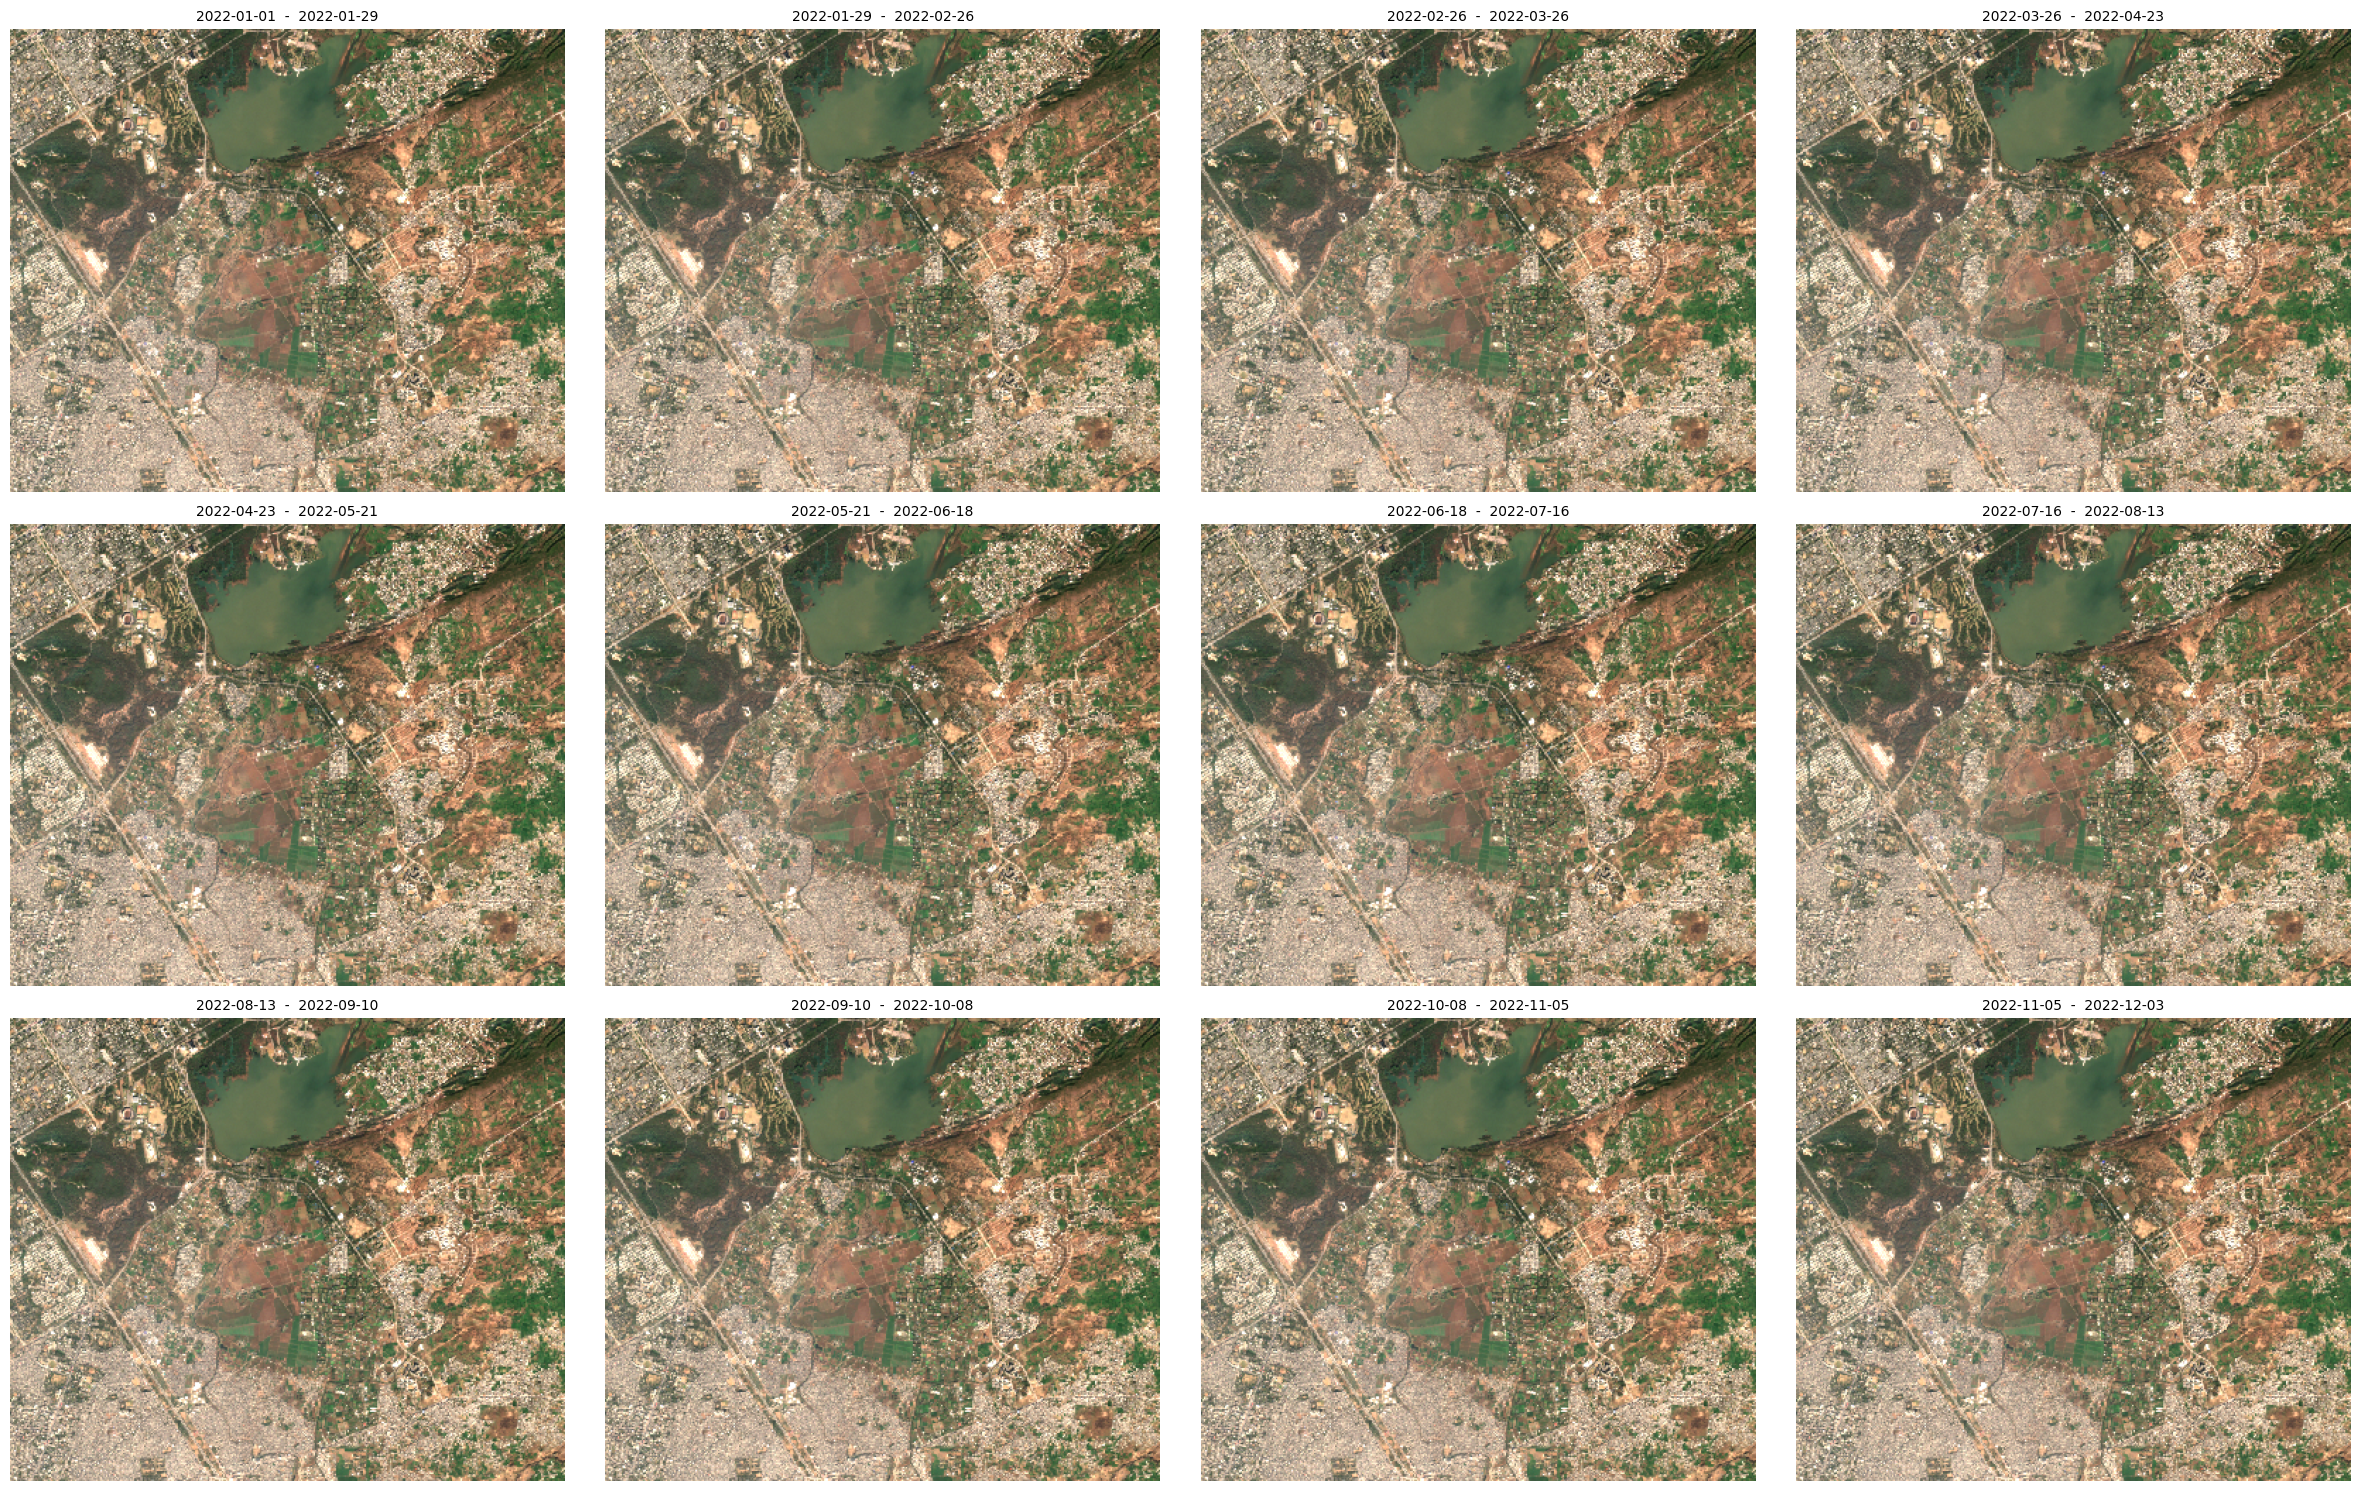

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# some stuff for pretty plots
ncols = 4
nrows = 3
aspect_ratio = image_size[0] / image_size[1]
subplot_kw = {"xticks": [], "yticks": [], "frame_on": False}

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols * aspect_ratio, 5 * nrows), subplot_kw=subplot_kw)

for idx, image in enumerate(data):
    ax = axs[idx // ncols][idx % ncols]
    ax.imshow(np.clip(image * 2.5 / 255, 0, 1))
    ax.set_title(f"{slots[idx][0]}  -  {slots[idx][1]}", fontsize=10)

plt.tight_layout()